# Compare Temperature Across Locations
* TMAX: The maximum temperature on a day
* TMIN: The minimum temperature on a day
* TAVG: (If available) The average temperature on a day
* [USDA Hardiness Zones](#usda_hardiness_zones)

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import functions
# from functions import map_stations

In [2]:
# Station 1 - Clatskanie
df = pd.read_csv('../data/temperature_97016.csv')
df = df.assign(year = pd.to_datetime(df['DATE']).dt.year)
df = df[df['year']<2025]

# Verify station 
# functions.view_station_date_ranges(df)
# geo_data = pd.read_csv('../data/geo_data.csv')
# functions.map_stations(geo_data)

df1 = df[df['STATION']=='USC00351643']
# df[df['TAVG'].notnull()]['STATION'].unique()

In [3]:
# Station 2 - Portland
df = pd.read_csv('../data/temperature_97218.csv')
df = df.assign(year = pd.to_datetime(df['DATE']).dt.year)
df = df[df['year']<2025]
df.STATION.unique()

df2 = df.copy()

In [4]:
# Merge the stations into one df
df1_suffix = '_CLATSKANIE'
df2_suffix = '_PDX'
df = df1.merge(df2,
          on=['DATE', 'year'],
          how='inner',
          suffixes=(df1_suffix, df2_suffix)
          ).drop(['STATION_PDX', 'STATION_CLATSKANIE'], axis=1)

In [5]:
df.describe()

,TAVG_CLATSKANIE,TMAX_CLATSKANIE,TMIN_CLATSKANIE,year,TAVG_PDX,TMAX_PDX,TMIN_PDX
count,0.0,30638.000000,30636.000000,30728.000000,6971.000000,30728.000000,30728.000000
mean,NaN,59.716888,42.249478,1982.389319,55.447138,62.787002,45.150807
std,NaN,12.642279,9.147526,24.323240,11.733747,14.488503,9.873956
min,NaN,17.000000,1.000000,1940.000000,18.000000,14.000000,-3.000000
25%,NaN,50.000000,35.000000,1961.000000,46.000000,52.000000,38.000000
50%,NaN,59.000000,42.000000,1982.000000,55.000000,61.000000,45.000000
75%,NaN,69.000000,50.000000,2003.000000,65.000000,73.000000,53.000000
max,NaN,103.000000,66.000000,2024.000000,96.000000,116.000000,75.000000


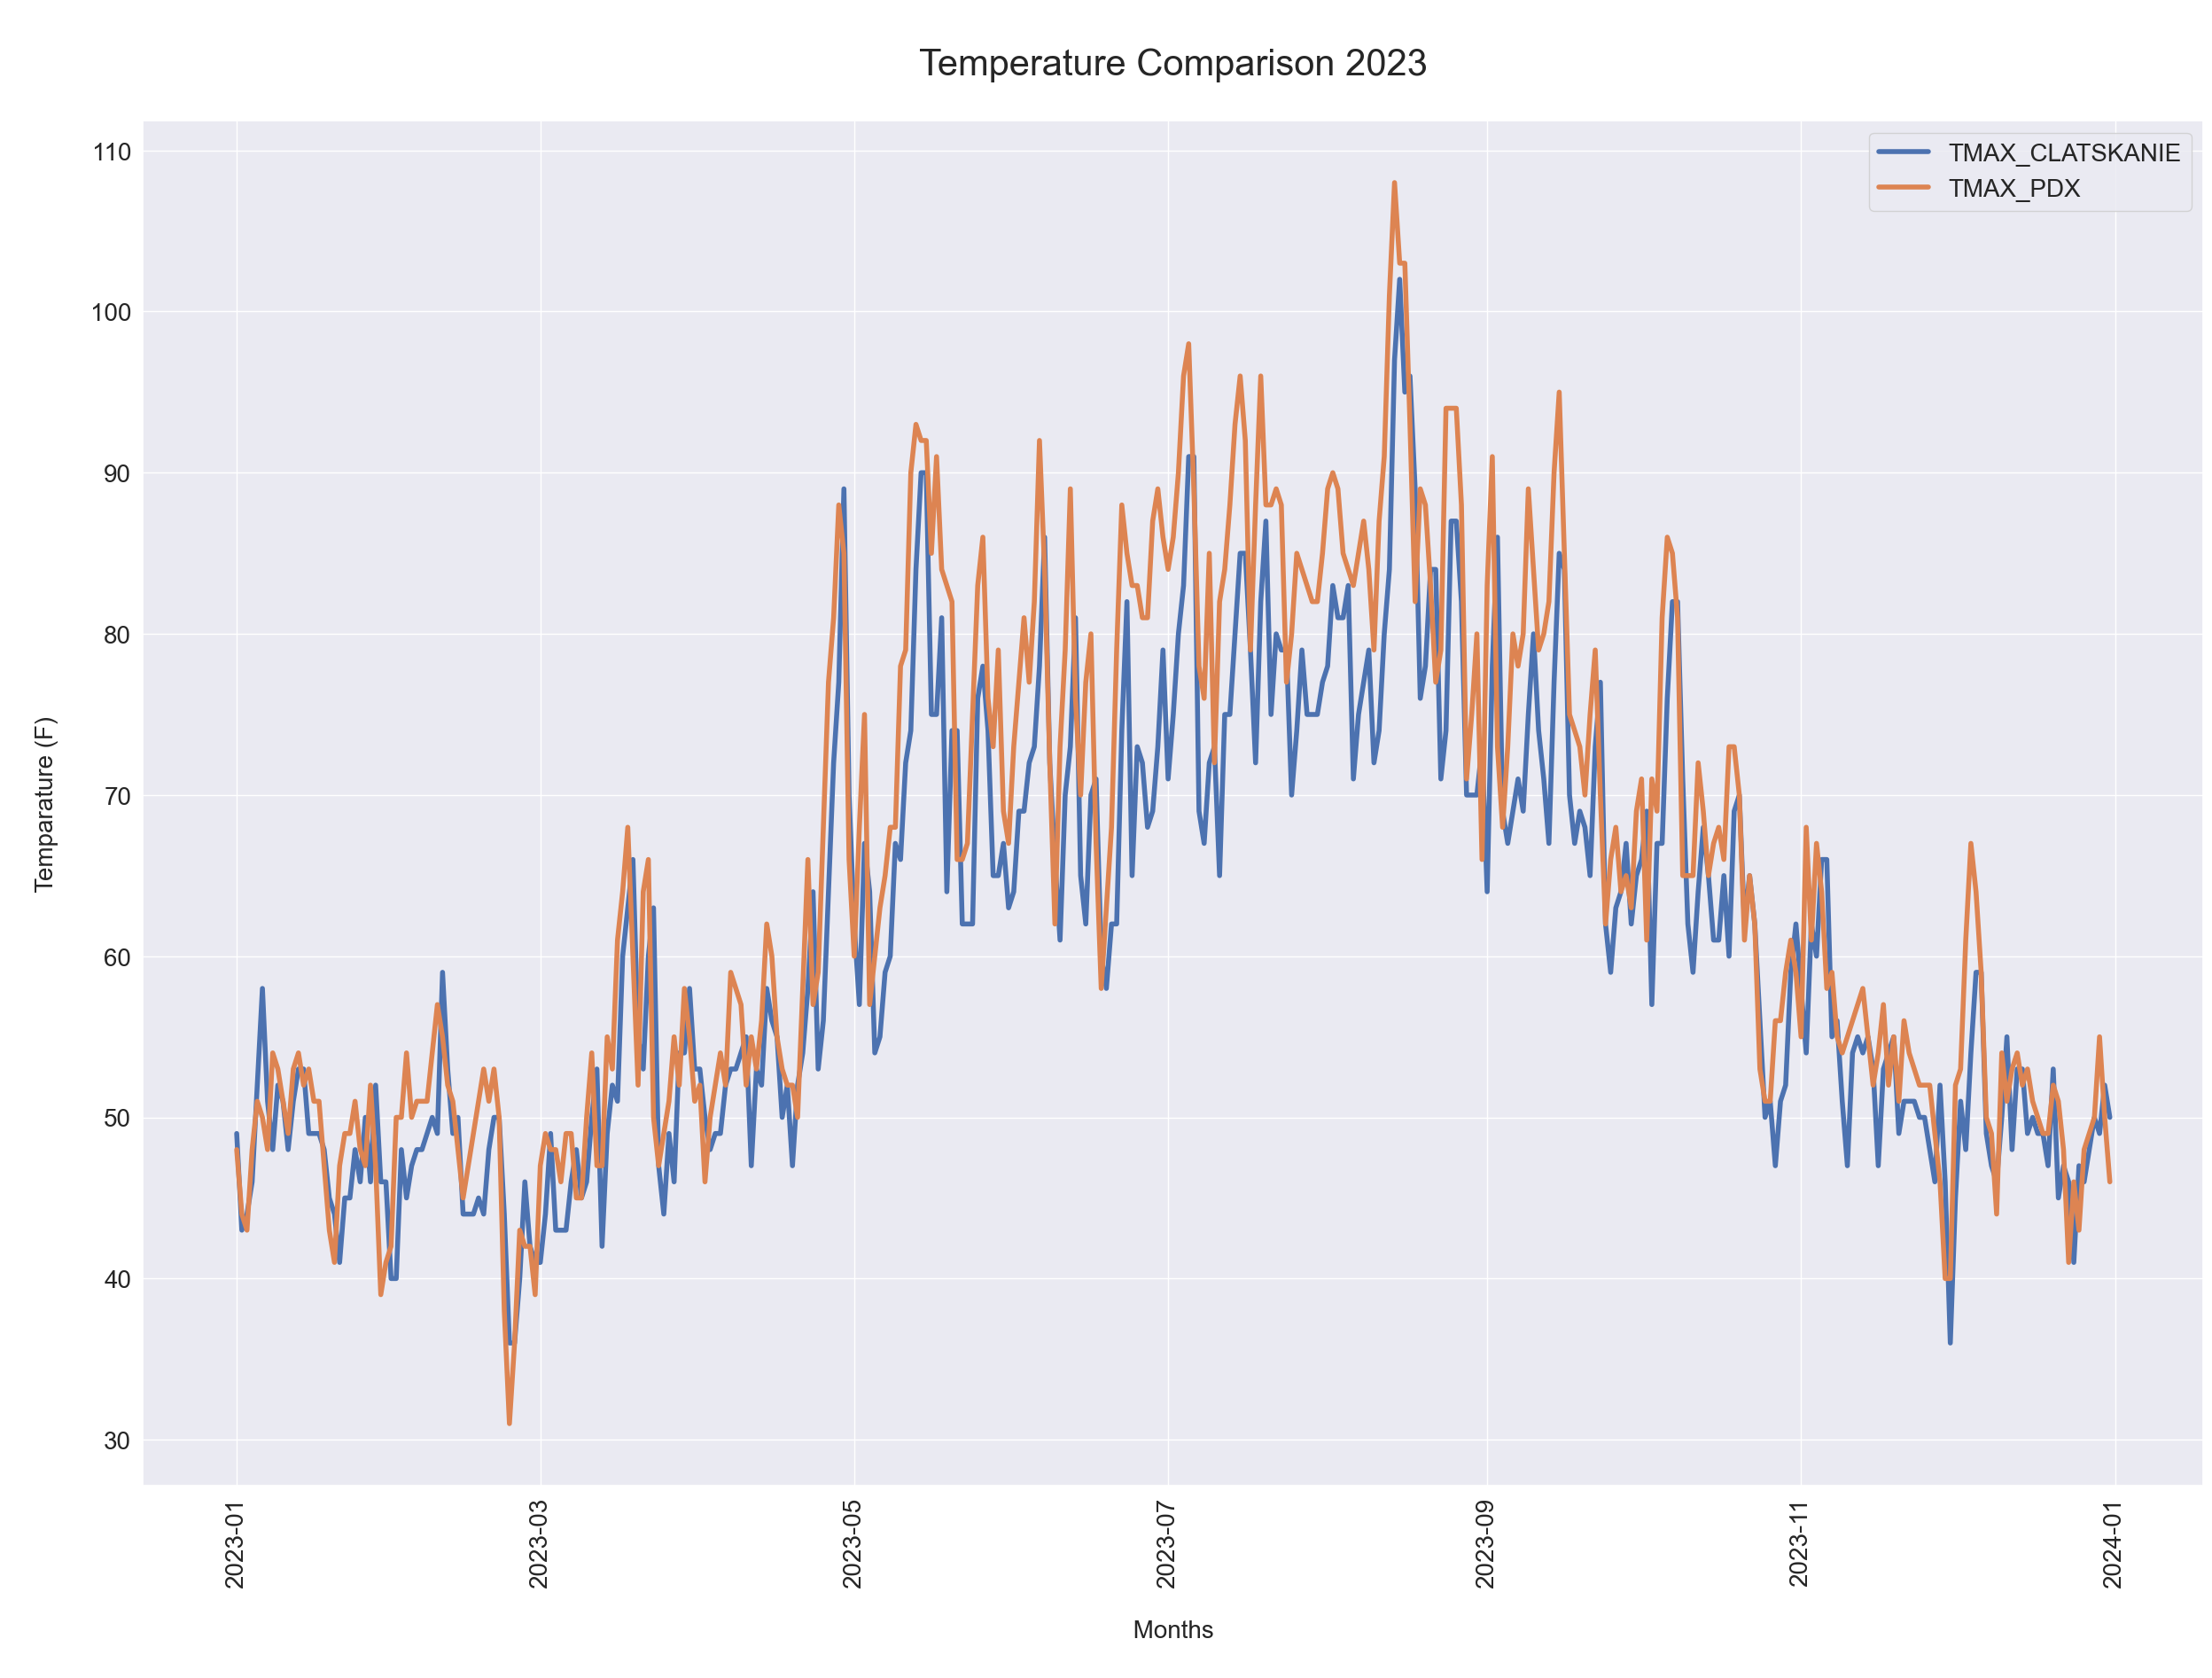

In [6]:
# Plot maximum temperature
pmax = functions.plot_temp_compare(df, 'TMAX', 2023)
# pmax.savefig('tmax_compare.jpg') 

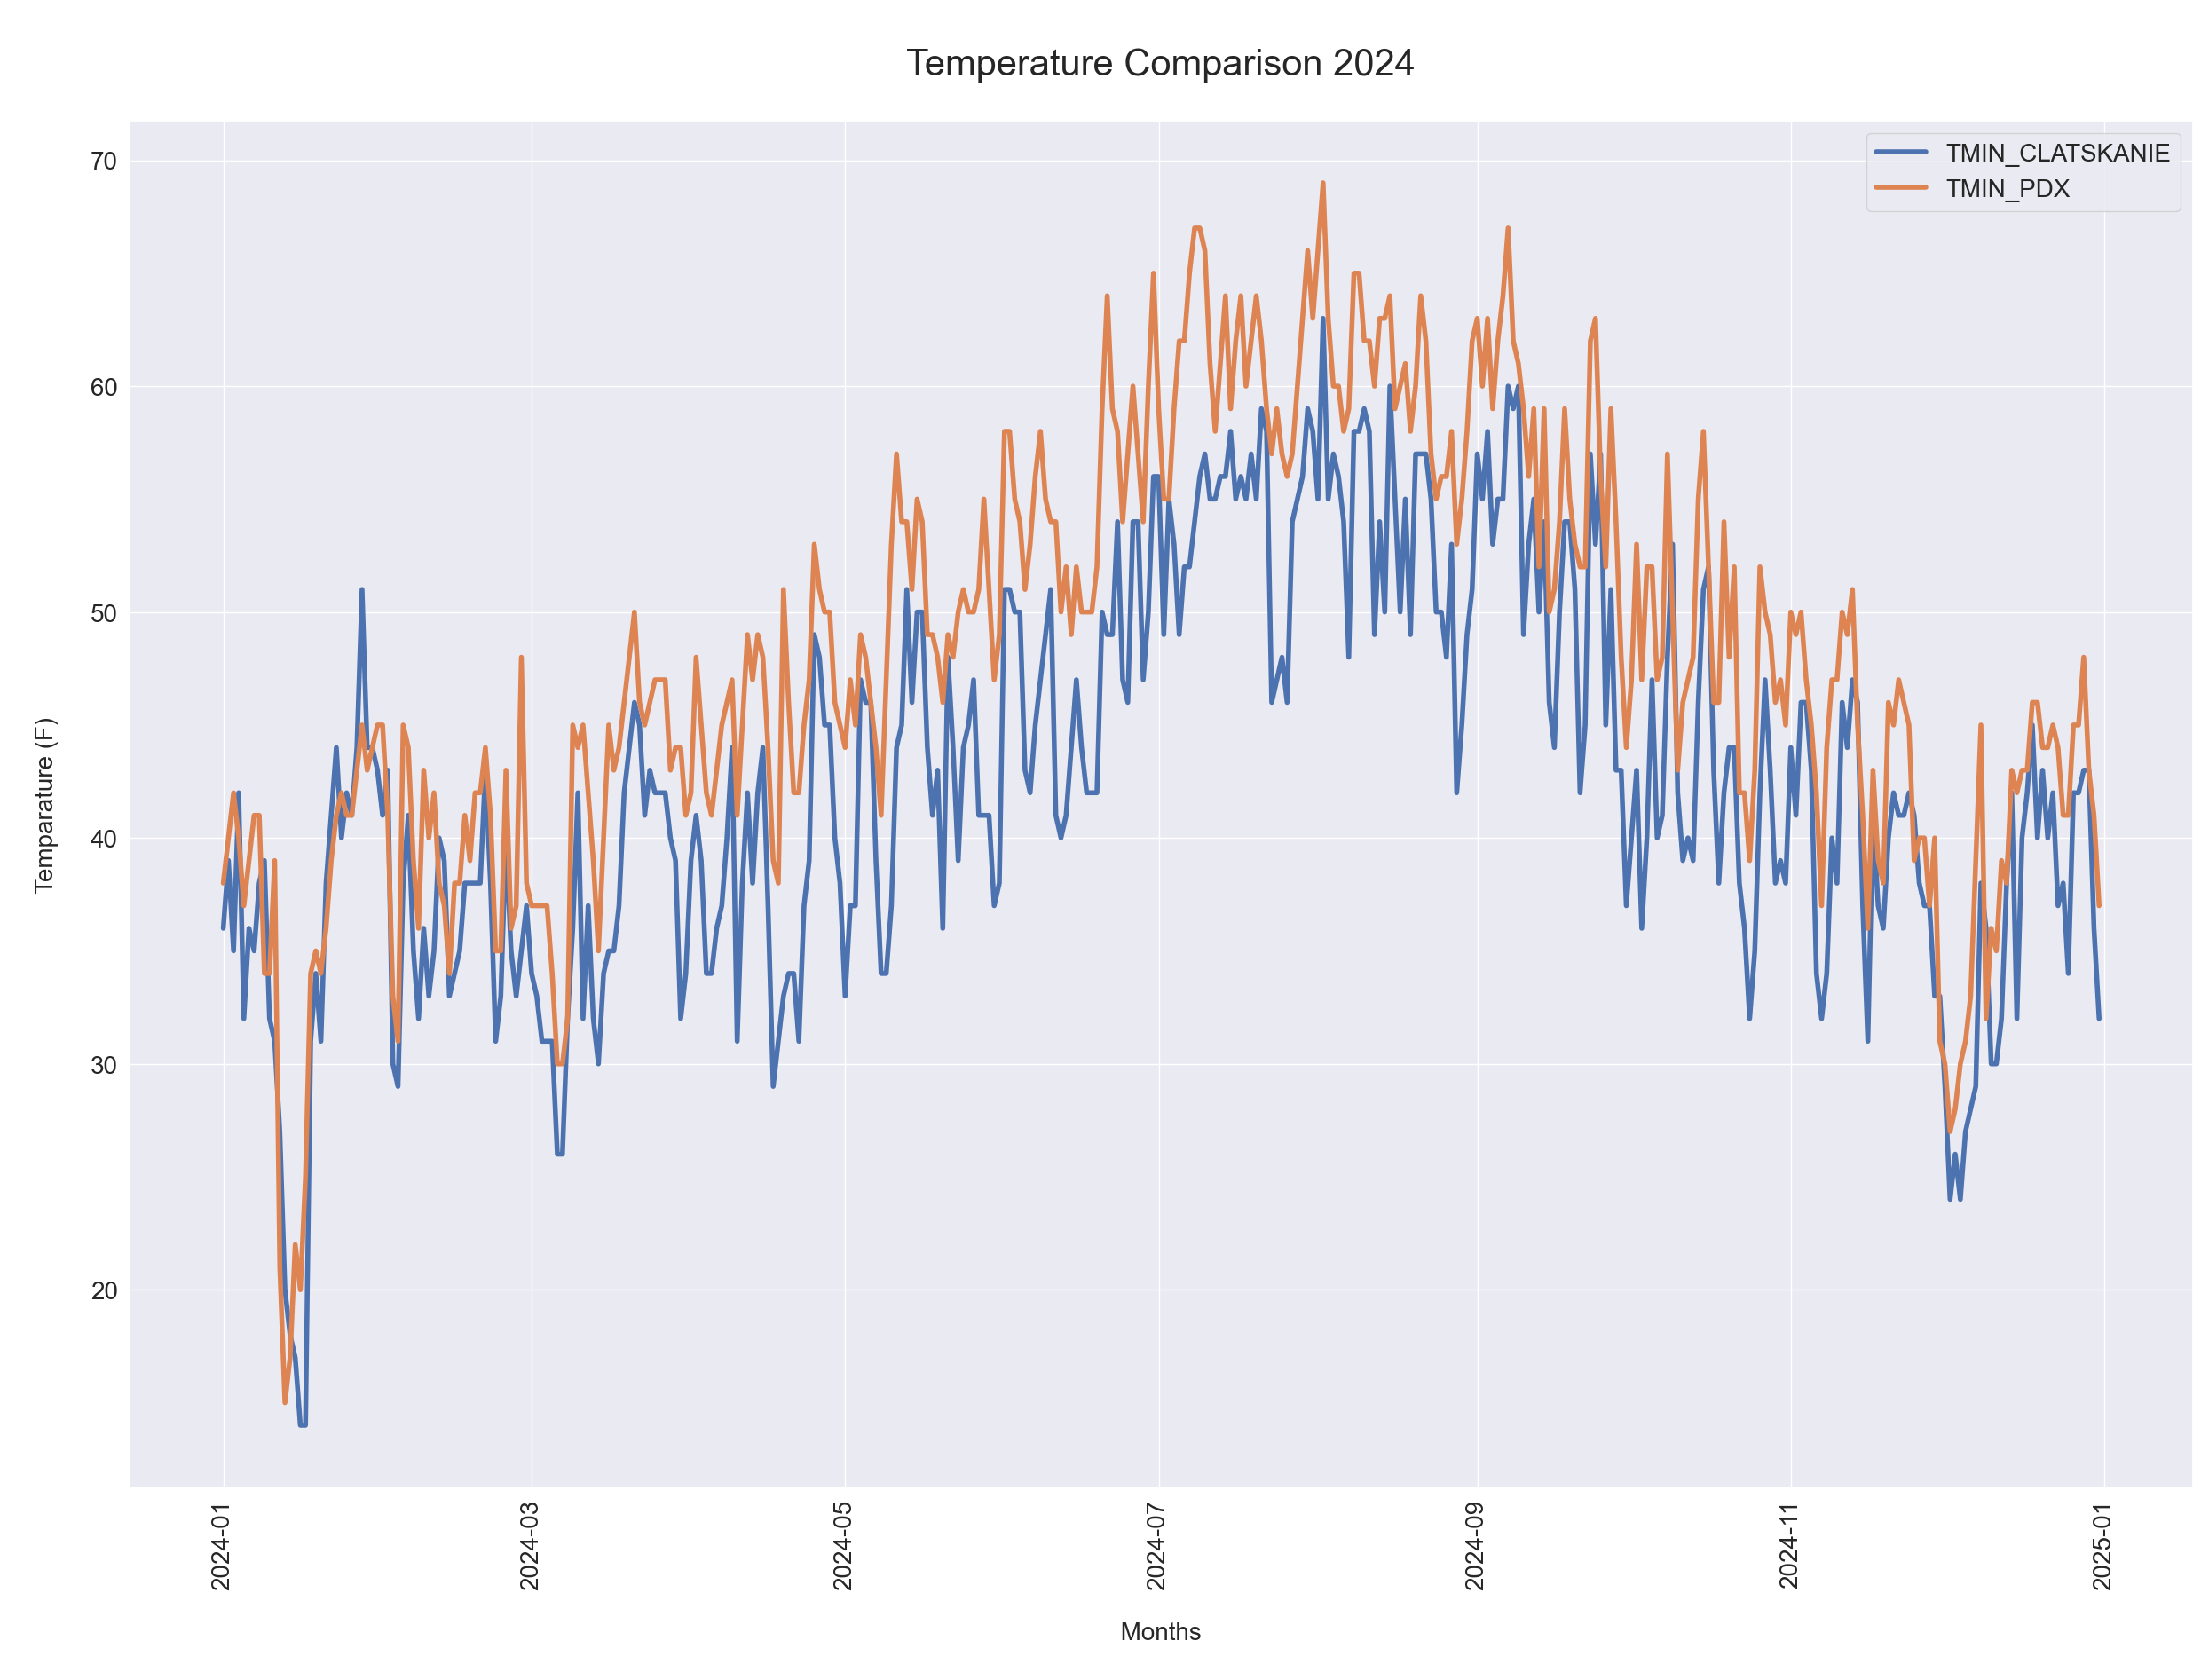

In [7]:
# Plot minimum temperature
pmin = functions.plot_temp_compare(df, 'TMIN', 2024)
# pmin.savefig('tmin_compare.jpg') 

<a id="usda_hardiness_zones"></a>

## USDA Hardiness Zones
* A USDA hardiness zone is defined by the minimum annual temperature at a station, averaged over the last 30 years
* For example, by this metric
    * USDA Zone 8a falls within 10°F and 15°F
    * USDA Zone 8b falls within 15°F and 20°F
    * USDA Zone 9a falls within 20°F and 25°F

In [8]:
# Get Daily Minimum Temperature data
df = pd.read_csv('../data/temperature_97016.csv')
df = df.assign(year = pd.to_datetime(df['DATE']).dt.year)
df = df.assign(month = pd.to_datetime(df['DATE']).dt.month)
df1 = df[df['STATION']=='USC00351643']
df = pd.read_csv('../data/temperature_97218.csv')
df2 = df.assign(year = pd.to_datetime(df['DATE']).dt.year)
df = df.assign(month = pd.to_datetime(df['DATE']).dt.month)

# Verify that there is only one station per df
assert len(df1.STATION.unique()) == 1
assert len(df2.STATION.unique()) == 1

# Merge the stations into one df
df1_suffix = '_CLATSKANIE'
df2_suffix = '_PDX'
df = df1.merge(df2,
          on=['DATE', 'year'],
          how='inner',
          suffixes=(df1_suffix, df2_suffix)
          ).drop(['STATION_PDX', 'STATION_CLATSKANIE'], axis=1)

In [9]:
# Get weather station location data 
df_stations = pd.read_csv('../data/geo_data.csv')
df_stations = df_stations[df_stations['STATION'].isin(list(set(df1['STATION'].unique()).union(df2['STATION'].unique())))]

# Map the stations 
functions.map_stations(df_stations,
                       default_lat=45.7,
                       default_long=-122.7,
                       default_zoom=9,)

In [10]:
# View the minimium temperature for each year
tmin = df.groupby('year', as_index=False).agg({'TMIN_CLATSKANIE': 'min', 'TMIN_PDX': 'min'})

# Check for null values
print('null values', tmin.isnull().sum().sum())

tmin

null values 0


,year,TMIN_CLATSKANIE,TMIN_PDX
0,1940,20.0,25
1,1941,25.0,24
2,1942,16.0,19
3,1943,9.0,3
4,1944,23.0,24
...,...,...,...
80,2020,24.0,27
81,2021,21.0,24
82,2022,20.0,20
83,2023,16.0,18


In [11]:
# Calculate the USDA hardiness zone for each station and year

# Calculate the trailing average TMIN_PDX for the last 30 years, for each year
tmin['PDX Hardiness Zone'] = tmin['TMIN_PDX'].rolling(window=30, min_periods=30).mean()
tmin['Clatskanie Hardiness Zone'] = tmin['TMIN_CLATSKANIE'].rolling(window=30, min_periods=30).mean()
tmin

,year,TMIN_CLATSKANIE,TMIN_PDX,PDX Hardiness Zone,Clatskanie Hardiness Zone
0,1940,20.0,25,NaN,NaN
1,1941,25.0,24,NaN,NaN
2,1942,16.0,19,NaN,NaN
3,1943,9.0,3,NaN,NaN
4,1944,23.0,24,NaN,NaN
...,...,...,...,...,...
80,2020,24.0,27,20.766667,16.666667
81,2021,21.0,24,20.900000,16.766667
82,2022,20.0,20,20.666667,16.733333
83,2023,16.0,18,20.666667,16.866667


In [12]:
# Make the wide format long, for the seaborn lineplot
tmin_long = tmin.melt(id_vars='year', value_vars=['TMIN_CLATSKANIE', 'TMIN_PDX'],
                      var_name='station', value_name='tmin')
tmin_long

,year,station,tmin
0,1940,TMIN_CLATSKANIE,20.0
1,1941,TMIN_CLATSKANIE,25.0
2,1942,TMIN_CLATSKANIE,16.0
3,1943,TMIN_CLATSKANIE,9.0
4,1944,TMIN_CLATSKANIE,23.0
...,...,...,...
165,2020,TMIN_PDX,27.0
166,2021,TMIN_PDX,24.0
167,2022,TMIN_PDX,20.0
168,2023,TMIN_PDX,18.0


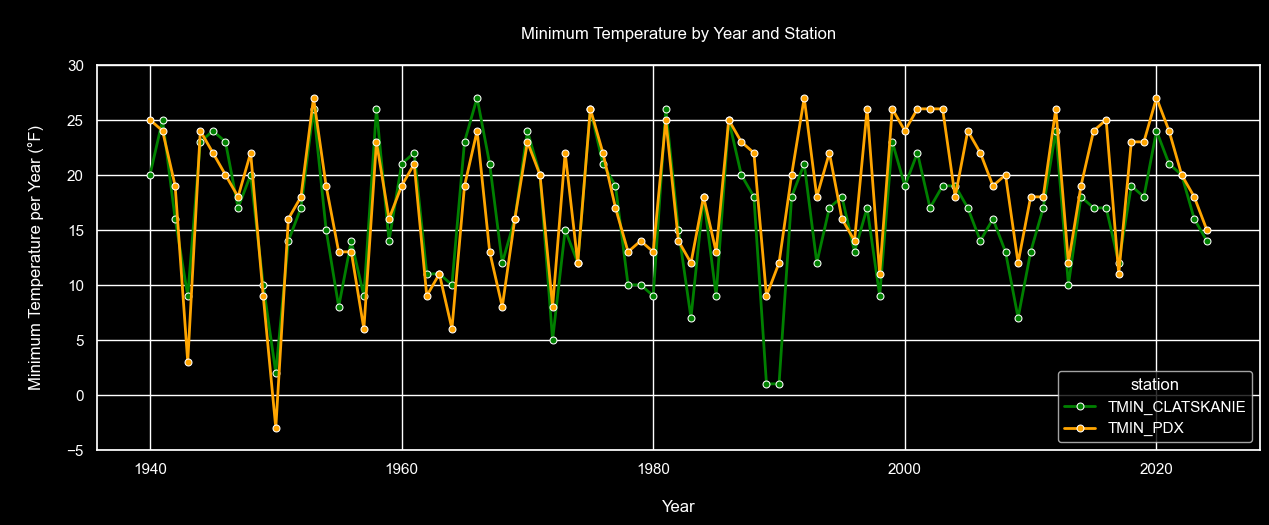

In [13]:
# sns.set_theme(style="darkgrid")
plt.style.use('dark_background')
plt.figure(figsize=(15,5))
p = sns.lineplot(data=tmin_long,
             x='year',
             y='tmin',
             hue='station',
             palette=['green', 'orange'],
             marker='o',    
             markersize=5,
             linewidth=2,
             style='station',
             dashes=False,
            #  legend='full',
                )

# add a title to the plot
plt.title('\nMinimum Temperature by Year and Station\n')
plt.ylim(-5, 30)
p.set_xlabel("\nYear", fontsize=12, rotation=0)
p.set_ylabel("\nMinimum Temperature per Year (°F)\n", fontsize=12, rotation=90)

# Suppress printouts
plt.show()


In [14]:
# How has the USDA hardiness zone changed year-by-year?
# This makes for better storytelling

# Make the wide format long, for the seaborn lineplot
usdahz = tmin.melt(id_vars='year', value_vars=['Clatskanie Hardiness Zone', 'PDX Hardiness Zone'],
                      var_name='station', value_name='USDA Hardiness Zone').dropna()
usdahz

,year,station,USDA Hardiness Zone
29,1969,Clatskanie Hardiness Zone,16.866667
30,1970,Clatskanie Hardiness Zone,17.000000
31,1971,Clatskanie Hardiness Zone,16.833333
32,1972,Clatskanie Hardiness Zone,16.466667
33,1973,Clatskanie Hardiness Zone,16.666667
...,...,...,...
165,2020,PDX Hardiness Zone,20.766667
166,2021,PDX Hardiness Zone,20.900000
167,2022,PDX Hardiness Zone,20.666667
168,2023,PDX Hardiness Zone,20.666667


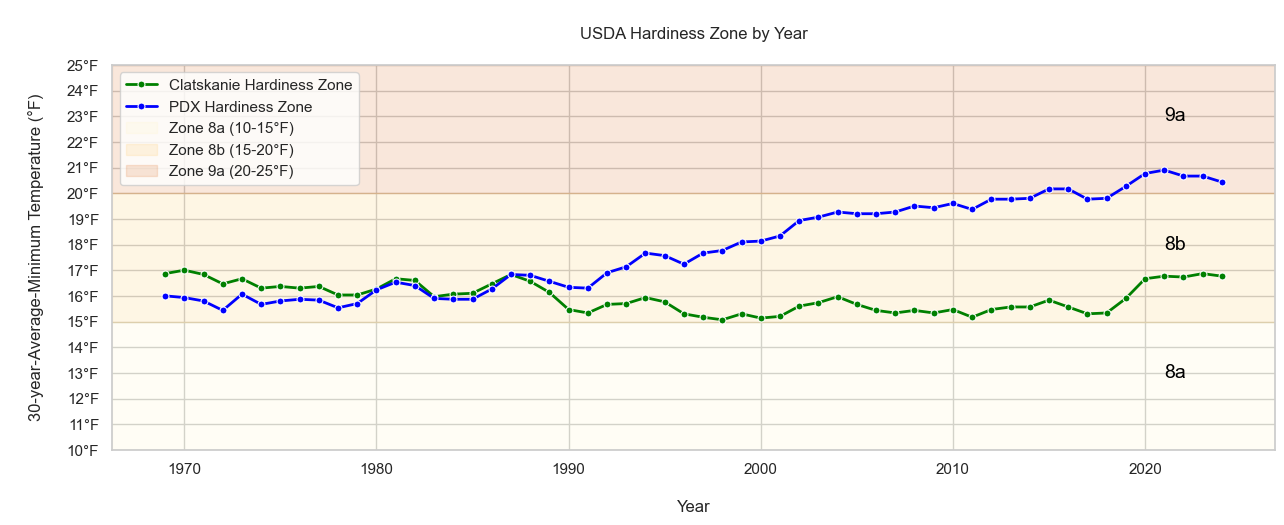

In [15]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,5))
p = sns.lineplot(data=usdahz,
             x='year',
             y='USDA Hardiness Zone',
             hue='station',
             palette=['green', 'blue'],
             marker='o',    
             markersize=5,
             linewidth=2,
             style='station',
             dashes=False,
                )

# Superimpose colored bands for USDA zones
# https://colorbrewer2.org/#type=sequential&scheme=YlOrBr&n=3
p.axhspan(10, 15, color='#fff7bc', alpha=0.15, label='Zone 8a (10-15°F)')
p.axhspan(15, 20, color='#fec44f', alpha=0.15, label='Zone 8b (15-20°F)')
p.axhspan(20, 25, color='#d95f0e', alpha=0.15, label='Zone 9a (20-25°F)')

# Add zone labels
p.text(x=2021, y=13, s='8a', color='black', fontsize=14, va='center')
p.text(2021, 18, '8b', color='black', fontsize=14, va='center')
p.text(2021, 23, '9a', color='black', fontsize=14, va='center')

plt.title('\nUSDA Hardiness Zone by Year\n')
plt.ylim(10, 25)
# label the y-axes for every interval of 1
p.set_yticks(np.arange(10, 26, 1))
p.set_yticklabels(['10°F', '11°F', '12°F', '13°F', '14°F', '15°F', '16°F', '17°F', '18°F', '19°F', '20°F', '21°F', '22°F', '23°F', '24°F', '25°F'])
p.set_xlabel("\nYear", fontsize=12, rotation=0)
p.set_ylabel("\n30-year-Average-Minimum Temperature (°F)\n", fontsize=12, rotation=90)

plt.legend(loc='upper left')
plt.show()